# 인코딩(encoding)과 디코딩(decoding)

- 인코딩-디코딩 아키텍쳐는 통신, 암호, 전자 등 다양한 분야에 적용되는 일반적인 프레임워크

- 인코더는 입력 샘플을 잠재 공간, 즉 인코더에 의해 정의된 숨겨진 구조화된 값 집합에 매핑하는 함수

- 디코더는 이 잠재 공간의 요소를 사전 정의된 타겟 도메인으로 매핑하는 여함수

- 예를 들어, 이미지와 오디오 압축 포맷

  - JPEG 도구는 미디어 파일을 가벼운 이진파일로 압축하여 인코딩하고, 표시할 떄 픽셀 값을 복원하기 위해 디코딩

  <img src="https://image.slidesharecdn.com/aes171113-180510014736/95/-48-638.jpg?cb=1525916931">

  <sub>[이미지 출처] https://www.slideshare.net/NaverEngineering/ss-96581209</sub>

# 오토인코더(Autoencoder, AE)

- 입력을 저차원 잠재공간으로 인코딩한 후 디코딩하여 복원하는 네트워크  
  즉, 이미지를 입력받아 인코더 모듈을 사용하여 잠재 벡터 공간으로 매핑하고,  
  디코더 모듈을 사용하여 원본 이미지와 동일한 차원으로 복원하여 출력

- 원본 입력을 재구성하는 방법으로 학습

- 고전적인 방식은 구조화가 잘된 잠재 공간을 만들지 못하고,  
  압축도 뛰어나지 않음

- 입력값과 출력값을 똑같이 줘서 입력값을 압축(저차원으로 축소)하여 동일한 값이 나오도록 학습하는 것
  * 별도의 레이블은 없지만 입력값을 출력값에 쓰이기 때문에 반지도학습이라고 함

  <img src="https://miro.medium.com/max/1200/1*nqzWupxC60iAH2dYrFT78Q.png">

  <sub>[이미지 출처] https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f</sub>

# Autoencoder 소개

이 튜토리얼에서는 3가지 예(기본 사항, 이미지 노이즈 제거 및 이상 감지)를 통해 autoencoder를 소개합니다.

autoencoder는 입력을 출력에 복사하도록 훈련된 특수한 유형의 신경망입니다. 예를 들어, 손으로 쓴 숫자의 이미지가 주어지면 autoencoder는 먼저 이미지를 더 낮은 차원의 잠재 표현으로 인코딩한 다음 잠재 표현을 다시 이미지로 디코딩합니다. autoencoder는 재구성 오류를 최소화하면서 데이터를 압축하는 방법을 학습합니다.

autoencoder에 대해 자세히 알아보려면 Ian Goodfellow, Yoshua Bengio 및 Aaron Courville의 [딥 러닝](https://www.deeplearningbook.org/)에서 14장을 읽어보세요.

## TensorFlow 및 기타 라이브러리 가져오기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## MNIST 데이터 세트 로드

시작하려면 Fashion MNIST 데이터세트를 사용하여 기본 autoender를 훈련, 이 데이터세트의 각 이미지는 28X28 픽셀

In [20]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## 첫 번째 예: 기본 autoencoder

[기본 오토 인코더 결과](https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

- 두 개의 Dense 레이어로 autoencoder를 정의
- 이미지를 64차원 잠재 벡터로 압축하는 `encoder`와 잠재 공간에서 원본 이미지를 재구성하는 `decoder`

- 모델을 정의하려면 [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models)를 사용

In [25]:
latent_dim = 64

class Autoencoder(Model):  #tensorflow.keras.models의 Model을 상속받아 그 안에 있는 모듈을 사용
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [26]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

- x_train을 입력과 대상으로 사용하여 모델을 훈련 \
encoder는 데이터세트를 784차원에서 잠재 공간으로 압축하는 방법을 배우고, decoder는 원본 이미지를 재구성하는 방법을 배움

In [27]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test,x_test))

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0235 - val_loss: 0.0130
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0101 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.008

- 모델이 훈련되었으므로 테스트 세트에서 이미지를 인코딩 및 디코딩하여 테스트하기

In [32]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  #display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 두 번째 예:  이미지 노이즈 제거

- autoencoder는 이미지에서 노이즈를 제거하도록 훈련될 수도 있음
- 다음 섹션에서는 각 이미지에 임의의 노이즈를 적용하여 Fashion MNIST 데이터세트의 노이즈 버전을 생성함
- 그런 다음 노이즈가 있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 사용하여 autoencoder를 훈련

- 이전에 수정한 내용을 생략하기 위해 데이터세트를 다시 가져오기

In [35]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]  #[] 안에 기존의 배열을 ...으로 적고, 추가하고 싶은 위치에 tf.newaxis를 적어주면 간단히 size가 변경됨
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


- 이미지에 임의의 노이즈를 추가

In [36]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

#clip_by_value()는 Tensor 값을 지정된 최솟값과 최댓값으로 자르는 데 사용
#구문: tensorflow.clip_by_value(t, clip_value_min=, clip_value_max=, name) 매개변수 t
x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

- 노이즈가 있는 이미지를 플롯

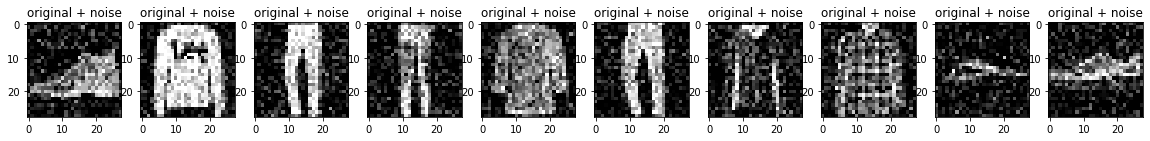

In [38]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))  #squeeze: 차원을 줄여주는 함수(크기가 1인 차원만 제거)
  plt.gray()
plt.show()

### 컨볼루셔널 autoencoder 정의하기

이 예제에서는 encoder에 Conv2D 레이어를 사용하고 decoder에 Conv2DTranspose 레이어를 사용하여 컨볼루셔널 autoencoder를 훈련

In [39]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
        layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)
    ])
    self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
    ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [40]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [41]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 69s 36ms/step - loss: 0.0161 - val_loss: 0.0096
Epoch 2/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 3/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 4/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 5/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 6/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 7/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 8/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 9/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/10
1875/1875 [==============================] - 69s 37m

- encoder 요약 보기 \
이미지가 28X28에서 7X7로 어떻게 다운샘플링 되는지 확인하기

In [42]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


- decoder 요약보기 \
이미지를 7X7에서 28X28로 다시 업샘플링

In [43]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


- autoencoder에서 생성된 노이즈가 있는 이미지와 노이즈가 제거된 이미지를 모두 플롯하기

In [44]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

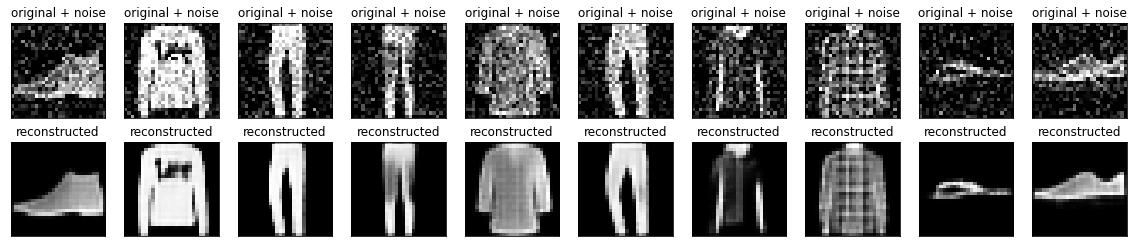

In [45]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
  #display original + noise
  ax = plt.subplot(2, n, i+1)
  plt.title("original + noise")
  plt.imshow(tf.squeeze(x_test_noisy[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #display reconstruction
  ax = plt.subplot(2, n, i+1+n)
  plt.title("reconstructed")
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 세 번째 예: 이상 감지

개요

- 이 예에서는 ECG5000 데이터세트에서 이상을 감지하도록 autoencoder를 훈련 \
 이 데이터세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 심전도가 포함되어 있음 \
  단순화 된 버전의 데이터세트를 사용하고, 각 예제는 0(비정상 리듬에 해당) 또는 1(정상 리듬에 해당)으로 레이블이 지정\
   여러분은 비정상 리듬을 식별하는 데 관심이 있음

- 참고: 레이블이 지정된 데이터세트를 사용하므로 지도 학습 문제라고 표현할 수 있음 \
이 예의 목표는 사용 가능한 레이블이 없는 더 큰 데이터세트에 적용할 수 있는 이상 감지 개념을 설명하는 것 \
(예: 정상 리듬이 수천 개이고 비정상 리듬이 적은 경우)

- autoencoder를 사용하여 이상을 어떻게 감지하겠습니까? \
autoencoder는 재구성 오류를 최소화하도록 훈련되었음 \
autoencoder는 정상 리듬으로만 훈련한 다음 이 autoencoder를 사용하여 모든 데이터를 재구성 \
여기서 가설은 비정상 리듬의 경우에 재구성 오류가 더 클 것이라는 것 \
그런 다음 재구성 오류가 고정 임계값을 초과하는 경우, 리듬을 이상으로 분류

- 보충 설명 : https://blog.daum.net/ejleep1/1227

### ECG 데이터 로드

사용할 데이터세트는 timeseriesclassification.com의 데이터세트를 기반 \
https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [47]:
#Download the dataset
dataframe = pd.read_csv("http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [48]:
dataframe.shape

(4998, 141)

In [49]:
dataframe.iloc[:, -1].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [50]:
#The last element contains the labels
labels = raw_data[:, -1]

#The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=.2, random_state=21
)

- 데이터를 [0,1]로 정규화 
  - tf.cast 함수 \
  텐서를 새로운 형태로 캐스팅하는데 사용 \
  부동소수점형에서 정수형으로 바꾼 경우 소수점 버림을 함 \
  Boolean 형태인 경우 True이면 1, False이면 0을 출력

In [51]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [54]:
print(train_data.shape)
print(test_data.shape)
print()
print(train_labels.shape)

(3998, 140)
(1000, 140)

(3998,)


- 이 데이터세트에서 1로 레이블이 지정된 정상 리듬만 사용하여 autoencoder를 훈련, \
정상 리듬과 비정상 리듬을 분리

In [55]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [56]:
pd.Series(train_labels).value_counts()

True     2359
False    1639
dtype: int64

In [57]:
normal_train_data.shape

TensorShape([2359, 140])

- 정상적인 ECG를 플롯

In [58]:
normal_train_data[0]

<tf.Tensor: shape=(140,), dtype=float32, numpy=
array([0.57030463, 0.46561658, 0.29058117, 0.17791584, 0.09538919,
       0.08467858, 0.20195104, 0.3163002 , 0.33732033, 0.41424882,
       0.47070596, 0.4691905 , 0.47767755, 0.4800409 , 0.47027245,
       0.4729927 , 0.47917148, 0.48027468, 0.4692887 , 0.46106863,
       0.46148038, 0.4465829 , 0.45325327, 0.45610094, 0.4489618 ,
       0.4432532 , 0.43402174, 0.44307235, 0.43250525, 0.43014902,
       0.41454658, 0.4120653 , 0.4042028 , 0.41054544, 0.4082913 ,
       0.40342993, 0.39648476, 0.39332044, 0.39158815, 0.39603877,
       0.40746954, 0.4053118 , 0.4173488 , 0.41624558, 0.42334118,
       0.44590637, 0.4455184 , 0.44474098, 0.44404328, 0.45673218,
       0.45217463, 0.4532504 , 0.46082932, 0.46695936, 0.46631944,
       0.4743283 , 0.4629709 , 0.4738895 , 0.46788898, 0.4673448 ,
       0.48026675, 0.4843984 , 0.48574668, 0.48985568, 0.49317348,
       0.4883041 , 0.49913937, 0.5057092 , 0.5078241 , 0.51323026,
       0.52119

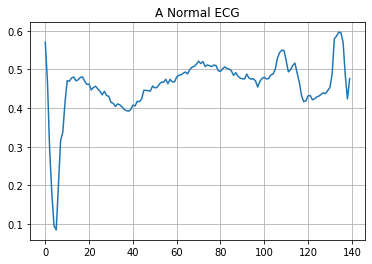

In [59]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

- 비정상적인 ECG를 플롯

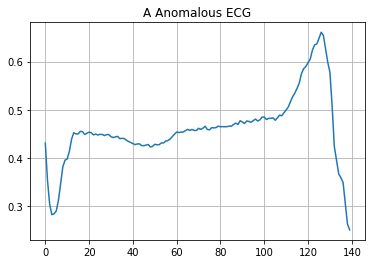

In [61]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("A Anomalous ECG")
plt.show()

### 모델 빌드하기

In [63]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu')
    ])
    self.decoder = tf.keras.Sequential([
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(140, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [64]:
autoencoder.compile(optimizer='adam', loss='mae')

- autoencoder는 일반 ECG만 사용하여 훈련되지만, 전체 테스트세트를 사용하여 평가

In [65]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                          epochs=20,
                          batch_size=512,
                          validation_data=(test_data, test_data),
                          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 47ms/step - loss: 0.0577 - val_loss: 0.0532
Epoch 2/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0551 - val_loss: 0.0516
Epoch 3/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0520 - val_loss: 0.0496
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0480 - val_loss: 0.0475
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0435 - val_loss: 0.0453
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0390 - val_loss: 0.0429
Epoch 7/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0353 - val_loss: 0.0411
Epoch 8/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0325 - val_loss: 0.0398
Epoch 9/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0302 - val_loss: 0.0391
Epoch 10/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0284 - val_loss: 0.0381
Epoch 11/20
5/5 [============

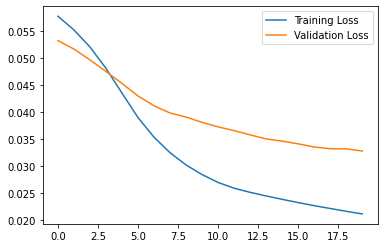

In [66]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

- 재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우, ECG를 비정상으로 분류 \
먼저, 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후의 재구성, 재구성 오류를 플롯

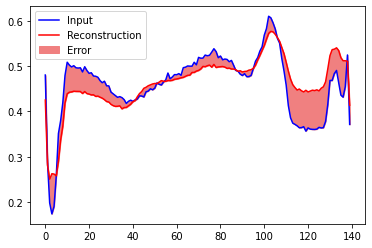

In [67]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

- 이번에는 비정상적인 테스트 예제에서 비슷한 플롯

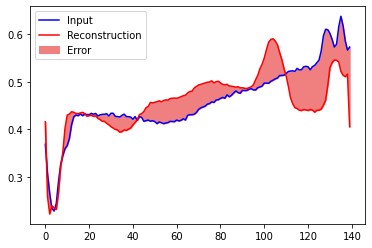

In [68]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### 이상 감지하기

- 재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상을 감지 \
이 튜토리얼에서는 훈련 세트에서 정상 예제에 대한 평균 오차를 계산한 다음, \
재구성 오류가 훈련 세트의 표준 편차보다 큰 경우 향후 예제를 비정상적인 것으로 분류

- 훈련 세트에서 정상 ECG에 대한 재구성 오류를 플롯

74/74 [==============================] - 0s 2ms/step


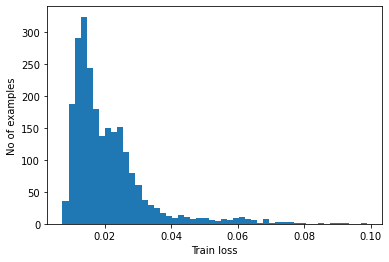

In [69]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

- 평균보다 표준 편차가 높은 임계값을 선택

In [70]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.032647982


- 참고: 테스트 예제를 이상 항목으로 분류하는 임계값을 선택하는 데 사용할 수 있는 다른 전략이 있음 \
올바른 접근 방식은 데이터세트에 따라 다름 \
이 튜토리얼의 끝에 있는 링크를 통해 더 많은 것을 배울 수 있음

- 테스트 세트에서 비정상적인 예제에 대한 재구성 오류를 조사하면 대부분 임계값보다 더 큰 재구성 오류가 있음을 알 수 있음 \
임계값을 변경하여 분류자의 정밀도와 재현율을 조정할 수 있음

14/14 [==============================] - 0s 2ms/step


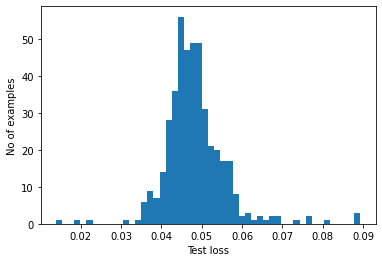

In [71]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

- 재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류

In [72]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
     

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714
